# Корректно ли работает система сплитования? АА-тест.

При проведении АА-теста было бы здорово убедиться в том, что наша система сплитования работает корректно, и ключевая метрика не отличается между 0 и 1 группой не только в конкретно нашем АА-тесте, но и в целом.

Мы будем многократно извлекать подвыборки с повторениями из наших данных, проводить t-test, и в конце посмотрим, в каком проценте случаев нам удалось отклонить нулевую гипотезу.

У нас есть данные АА-теста с '2022-03-28' по '2022-04-03'. Вам нужно сделать симуляцию, как будто мы провели 10000 АА-тестов. На каждой итерации вам нужно сформировать подвыборки с повторением в 500 юзеров из 2 и 3 экспериментальной группы. Провести сравнение этих подвыборок t-testом.

1. Построить гистограмму распределения получившихся 10000 p-values.

2. Посчитать, какой процент p values оказался меньше либо равен 0.05

3. Написать вывод по проведенному АА-тесту, корректно ли работает наша система сплитования.

In [57]:
# Импортируем необходимые библиотеки

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandahouse
from scipy import stats

## Загружаем данные

In [5]:
# Загружаем датасет
# Подключаемся к БД
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator_20220420'
}
# Запрос к БД
# Данные о количестве пользователей, просмотров, лайков и сообщений в приложении за неделю
q = '''
    SELECT 
        exp_group, user_id,  
        countIf(action='like') as likes,
        countIf(action='view') as views,
        countIf(action='like')/countIf(action='view') as ctr
    FROM
        simulator_20220420.feed_actions
    WHERE 
        (toDate(time) BETWEEN '2022-03-28' AND '2022-04-03') 
        AND (exp_group IN (2, 3))
    GROUP BY
        user_id, exp_group
'''
# Сохраним результат запроса в pandas df
df = pandahouse.read_clickhouse(q, connection=connection)

In [8]:
df

,exp_group,user_id,likes,views,ctr
0,3,115383,11,36,0.305556
1,3,123580,15,92,0.163043
2,2,131473,26,148,0.175676
3,2,23985,12,66,0.181818
4,2,24523,17,120,0.141667
...,...,...,...,...,...
17044,3,122008,4,31,0.129032
17045,2,25383,16,57,0.280702
17046,3,122190,25,74,0.337838
17047,2,108927,8,33,0.242424


## EDA

Проверим наши экспериментальные группы (2 и 3) на "одинаковость".

In [21]:
# Зададим параметры графиков
sns.set(rc={"figure.figsize":(12, 6)}) 
plt.tight_layout()

<Figure size 864x432 with 0 Axes>

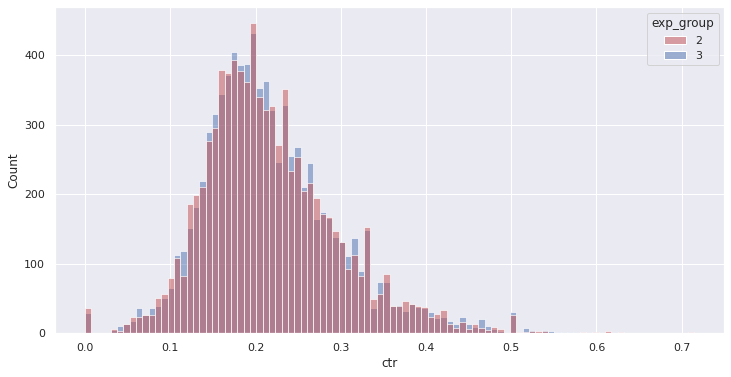

In [24]:
# Проверяем по CTR
ax = sns.histplot(data=df, x='ctr', hue='exp_group', palette=['r', 'b'])

Распределение отдаленно похоже на нормальное, также есть выбросы.  
Визуально обе группы похожи. Проверим это t-тестом и тестом Манна-Уитни.

In [30]:
# t-критерий Стьюдента
# H0 - средние двух групп равны; 
# H1 - средние двух групп не равны
stats.ttest_ind(df[df['exp_group']==2].ctr, 
                df[df['exp_group']==3].ctr, 
                equal_var=False)

Ttest_indResult(statistic=-0.7393597924958364, pvalue=0.45969873156476293)

In [31]:
# # тест Манна-Уитни
# # H0 - сумма рангов в обеих группах [примерно] равна; 
# # H1 - сумма рангов не равна
# stats.mannwhitneyu(df[df.exp_group == 2].ctr, 
#                    df[df.exp_group == 3].ctr)

MannwhitneyuResult(statistic=36124728.5, pvalue=0.5177480614337441)

По результатам обоих тестов можем принять H0.  
Но это один АА-тест. Чтобы получить представление о генеральной совокупности каждой из групп, проведем 10000 тестов.

## Симуляция 10000 АА-тестов

In [34]:
# Симуляция 10000 АА-тестов на выборках по 500 пользователей из каждой группы
n_tests = 10000
n_samples = 500
p_values_list = []
for i in range(n_tests):
    group_2 = df[df['exp_group']==2].ctr.sample(n_samples, replace=True)
    group_3 = df[df['exp_group']==3].ctr.sample(n_samples, replace=True)
    # Т-тест
    p_value = stats.ttest_ind(group_2, group_3, equal_var=False)[1]
    p_values_list.append(p_value)

CPU times: user 31 s, sys: 13.3 ms, total: 31 s
Wall time: 31 s


In [38]:
p_values_list[:5]

[0.6373527513780219,
 0.13007506819340273,
 0.08019333378329141,
 0.8769837437668251,
 0.1700037206389963]

### 1. Гистограмма распределения получившихся 10000 p-values

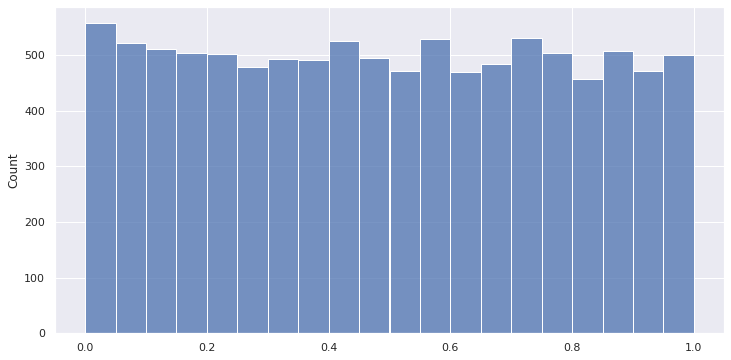

In [56]:
ax = sns.histplot(p_values_list, bins=20)

### 2. Какой процент p values оказался меньше либо равен 0.05

In [50]:
p_values = pd.Series(p_values_list)
prcnt = 100 * len(p_values[p_values<=0.05]) / len(p_values)
print("Всего p-values <= 0.05:", f"{prcnt}%")

Всего p-values <= 0.05: 5.57%


### 3. Вывод

* Распределение p-values равномерное.
* Всего в 5.57% случаев p-value оказалось ниже или равно 0.05.  

Следовательно, система сплитования работает корректно - можем тестировать новые функции на группах 2 и 3.